# Лабораторная работа №4
Подготовили Бахтаиров Роман 408233 и Сайфуллин Динислам 409502

Как всегда, импорты

In [144]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Это не плагиат, если украл у себя...
Переписываем полезный код из предыдущих работ: подгрузка и показ изображения

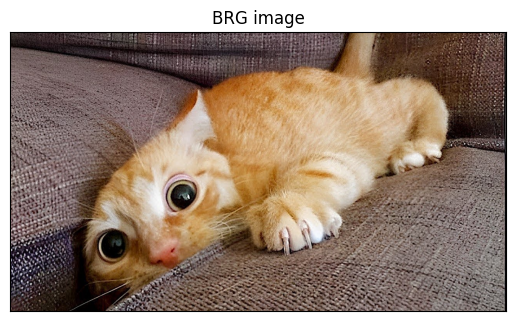

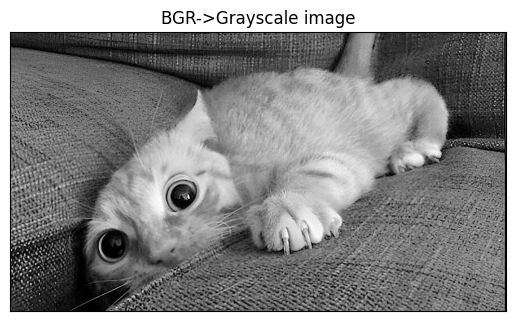

In [145]:
fn = "images/funny_cat.jpg"
fn2 = "images/human_face.jpg"
fn3= 'images/test3.jpg'
fn4 = 'images/clouds3.jpg'
I = cv.imread(fn, cv.IMREAD_COLOR)
I_2 = cv.imread(fn2, cv.IMREAD_COLOR)
I_3 = cv.imread(fn3, cv.IMREAD_COLOR)
I_4 =  cv.imread(fn4, cv.IMREAD_COLOR)
I2gray = cv.cvtColor(I_2, cv.COLOR_BGR2GRAY)
I3gray =  cv.cvtColor(I_3, cv.COLOR_BGR2GRAY)
I4gray = cv.cvtColor(I_4, cv.COLOR_BGR2GRAY)
if not isinstance(I, np.ndarray) or I.data == None:
  print("Error reading file \"{}\"".format(fn))
else:
  Igray = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
def ShowImages(Is, ncols = 0, hide_axes = True):
  if len(Is) == 0:
    return

  # Show images one-by-one
  if len(Is) == 1 or ncols == 0:
    for I in Is:
      if I == None:
        continue

      if I[1].ndim == 2:
        axes = plt.imshow(I[1], cmap='gray')
      else:
        axes = plt.imshow(cv.cvtColor(I[1], cv.COLOR_BGR2RGB))
      plt.title(I[0])

      # If we don't need axes display, then let's hide it
      if hide_axes:
        axes.axes.get_xaxis().set_visible(False)
        axes.axes.get_yaxis().set_visible(False)

      # And now show image
      plt.show()
    return

  # Show images side-by-side
  fig, axes = plt.subplots(nrows = (len(Is) + ncols - 1) // ncols, ncols = ncols)
  axes = axes.flatten()
  for i in range(len(Is)):
    if Is[i] != None:
      if Is[i][1].ndim == 2:
        axes[i].imshow(Is[i][1], cmap='gray')
      else:
        axes[i].imshow(cv.cvtColor(Is[i][1], cv.COLOR_BGR2RGB))
      axes[i].set_title(Is[i][0])

    # If we don't need axes display, then let's hide it
    if hide_axes:
      axes[i].axes.get_xaxis().set_visible(False)
      axes[i].axes.get_yaxis().set_visible(False)

  for i in range(len(Is), ncols * ((len(Is) + ncols - 1) // ncols)):
    axes[i].set_visible(False)

  # And now show image
  plt.show()

# Now we can use this function to display two images
ShowImages([("BRG image", I),
            ("BGR->Grayscale image", Igray)], 0, True)

# Так ты у нас этот, небинарный?
Займёмся бинаризацией изображения, а именно слеующими видами:
- Сами выберем пороги бинаризации
- Посчитаем порог простенько(по среднему арифметическому)
- Посчитаем на основе модуля градиента яркости
- Посчитаем методом Отсу(Otsu)

### Бинаризируем изображение как хотим

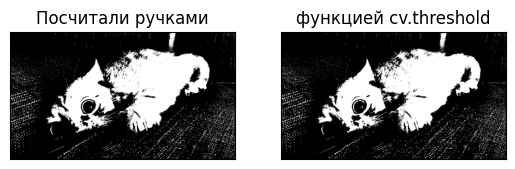

In [146]:
t_ceiling = 255
t_floor = 150
handy_binarized_I =  Igray.copy()
mask = (handy_binarized_I > t_floor) & (handy_binarized_I < t_ceiling)
handy_binarized_I[mask] = 255
handy_binarized_I[~mask] = 0 
_, cv_binarized_I = cv.threshold(Igray, t_floor, t_ceiling, cv.THRESH_BINARY)
ShowImages([("Посчитали ручками", handy_binarized_I),
            ("функцией cv.threshold", cv_binarized_I)], 2, True)

##### Как видно, изображения совпали

### Бинаризируем по среднему арифметическому

127.5


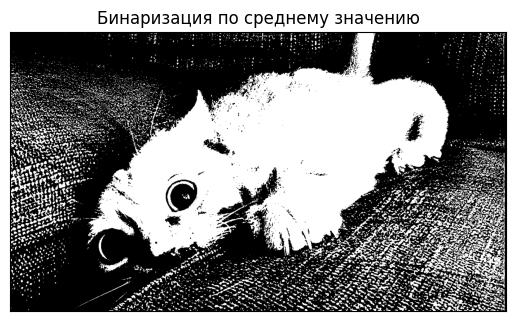

In [156]:
t_average = (Igray.max() - Igray.min())/2
print(t_average)
_, cv_binarized_I = cv.threshold(Igray, t_average, 255, cv.THRESH_BINARY)
ShowImages([("Бинаризация по среднему значению", cv_binarized_I)], 0, True)

### Бинаризация по модулю градиента

101


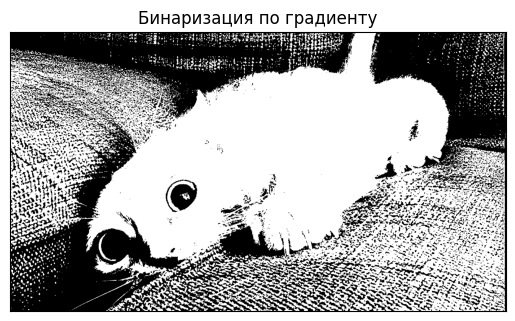

In [148]:
Igray = Igray.astype(np.uint8)
def G(x, y, Igray):
    height, width = Igray.shape
    if x <= 0 or x >= height-1 or y <= 0 or y >= width-1:
        return 0
    diff1 = np.int64(Igray[x+1, y]) - np.int64(Igray[x-1, y])
    diff2 = np.int64(Igray[x, y+1]) - np.int64(Igray[x, y-1])
    return max(abs(diff1), abs(diff2))
upper_sum = np.int64(0)
down_sum = np.int64(0)

for x in range(1, Igray.shape[0]-1):
    for y in range(1, Igray.shape[1]-1):
        grad = G(x, y, Igray)
        upper_sum += Igray[x, y] * grad
        down_sum += grad
t_grad = int(round(upper_sum / down_sum))
print(t_grad)
_, cv_binarized_I = cv.threshold(Igray, t_grad, 255, cv.THRESH_BINARY)
ShowImages([("Бинаризация по градиенту", cv_binarized_I)], 0, True)

### Метод Отсу
Погружение в статистику

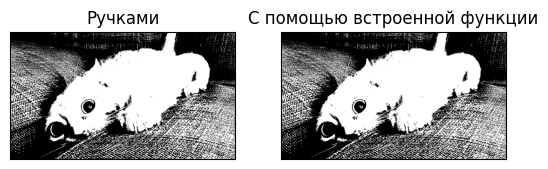

True
113


In [149]:
hist = cv.calcHist([Igray], [0], None, [256], [0, 256])[:, 0]
p_histogram = hist/Igray.size
t= 0 
max_val =0
L = Igray.max()
for k in range(1, L):
    w_1 = sum(p_histogram[:k+1])
    w_2 = 1- w_1
    mu_1 = 0
    mu_2 = 0
    for i in range(k+1):
        mu_1+= (i * p_histogram[i])/w_1
    for i in range(k+1,L+1):
        mu_2+= (i * p_histogram[i])/w_2
    dispers = w_1*w_2*(mu_1-mu_2)**2
    if dispers >max_val:
        t=k
        max_val = dispers

_, cv_binarized_I = cv.threshold(Igray, t, 255, cv.THRESH_BINARY)
_, otsu_binarized_I = cv.threshold(Igray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
ShowImages([("Ручками", cv_binarized_I),("С помощью встроенной функции", otsu_binarized_I) ], 2, True)
print(cv_binarized_I.all()== otsu_binarized_I.all())
print(t)

### Адаптивная бинаризация

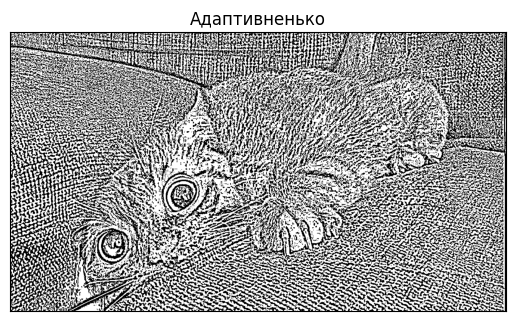

In [150]:
I_adaptive = cv.adaptiveThreshold(
    Igray, 255, cv.ADAPTIVE_THRESH_MEAN_C,
    cv.THRESH_BINARY, 11, 2
)
ShowImages([("Адаптивненько", I_adaptive)], 0, True)


---

# Сегментация изображения

### Сегментация 1
Сегментируем по принципу Вебера

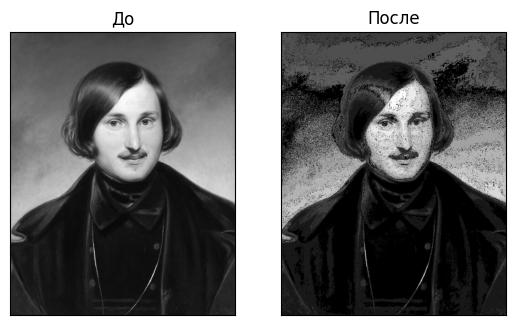

In [151]:

def weber_function(I):
    if 0 <= I <= 88:
        return 20 - (12 * I) / 88
    elif 88 < I <= 138:
        return 0.002 * (I - 88)**2
    elif 138 < I <= 255:
        return (7 * (I - 138)) / 117 + 13
    else:
        return 0

segmented_image = np.zeros_like(I2gray)
n = 1  
I_n = 0  
while True:
    W = weber_function(I_n)
    lower = I_n
    upper = I_n + W
    mask = (I2gray >= lower) & (I2gray <= upper)
    segmented_image[mask] = I_n
    
    G = upper + 1
    next_pixels = I2gray[I2gray > G]
    
    if next_pixels.size > 0:
        I_n = G
        n += 1
    else:
        break

ShowImages([("До", I2gray), ("После", segmented_image) ], 2, True)
    


### Сегментация 2
В ход пойдут цвета...
В данном задании перейдем из цветового профиля RGB в профиль CIE Lab, и разложим изображения на сегменты по методу ближайших соседей

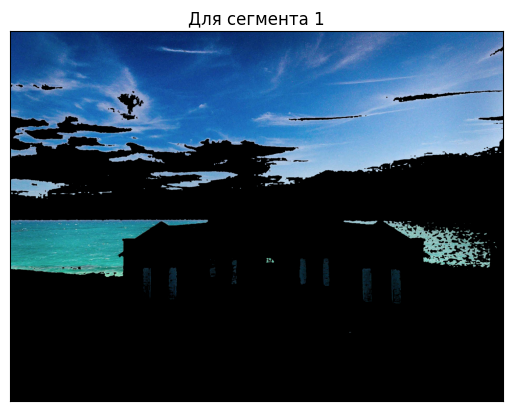

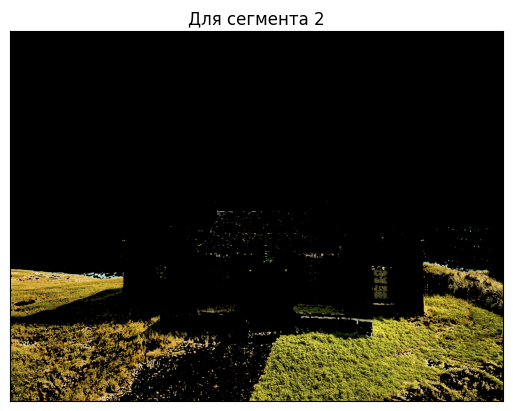

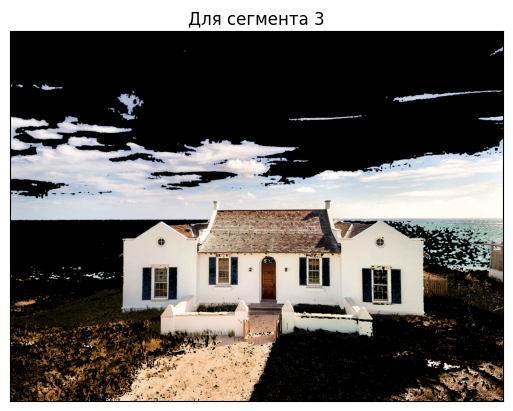

In [152]:
I_for_segmentation = I_3.copy()
Ilab = cv.cvtColor(I_for_segmentation, cv.COLOR_RGB2LAB)
L = Ilab[:,:,0]
a =  Ilab[:,:,1]
b = Ilab[:,:,2]

numColors = 3
sample_regions = [
    (100, 100, 50, 50),  # (x,y,width,height) 
    (100, 1000, 50, 50),  
    (900, 700, 50, 50)   
]
sampleAreas = np.zeros((I_for_segmentation.shape[0], I_for_segmentation.shape[1], numColors), dtype=bool)
for i in range(numColors):
    x, y, w, h = sample_regions[i]
    sampleAreas[y:y+h, x:x+w, i] = True

colorMarks = np.zeros((numColors, 2))
for i in range(numColors):
    colorMarks[i, 0] = np.mean(a[sampleAreas[:,:, i]])
    colorMarks[i, 1] = np.mean(b[sampleAreas[:,:, i]])

distance = np.zeros((a.shape[0], a.shape[1], numColors))
for i in range(numColors):
    distance[:,:, i] = ((a - colorMarks[i, 0])**2 + (b - colorMarks[i, 1])**2)**(1/2)

label = np.argmin(distance, axis=2)

segmentedFrames = np.zeros((I_for_segmentation.shape[0], I_for_segmentation.shape[1], 3, numColors), dtype=np.uint8)

for i in range(numColors):
    just_saver = I_for_segmentation.copy()
    just_saver[label != i] = (0,0,0)
    segmentedFrames[:,:,:, i] = just_saver
ShowImages([("Для сегмента 1", segmentedFrames[:,:,:,0]),("Для сегмента 2", segmentedFrames[:,:,:,1]) ,("Для сегмента 3", segmentedFrames[:,:,:,2])], 0, True)


### Сегментация 3
В данном разделе попробуем определить текстурные зоны на изображениях

In [153]:
frame_size = (4,4)
R_related = np.zeros((I4gray.shape[0],I4gray.shape[1]))
for x in range(4, I4gray.shape[0]-4):
    for y in range(4, I4gray.shape[1] -4):
        width = frame_size[0]//2
        hight = frame_size[1]//2
        local_frame_probe = I4gray[x-width:x+width, y-hight:y+hight]
        m = np.mean(local_frame_probe)
        R_related[x,y] = 1- 1/(1+np.sum((local_frame_probe - m)**2)/local_frame_probe.size) 

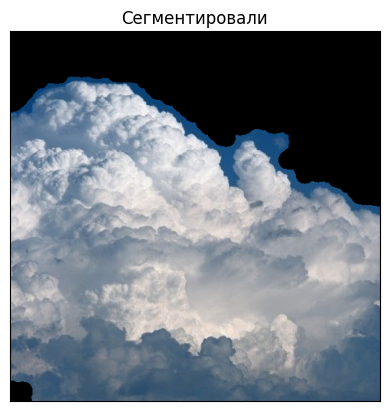

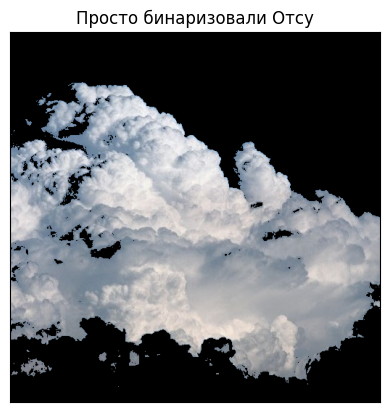

In [154]:

def imclose(img, kernel_size=25, iterations=1):# Так как в openCV бог данных функций не послал, мы делаем это сами
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel, iterations=iterations)
def bwareaopen(image, min_area, connectivity=8):
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(image, connectivity=connectivity)
    mask = np.zeros_like(image, dtype=np.uint8)
    for i in range(1, num_labels):
        if stats[i, cv.CC_STAT_AREA] >= min_area:
            mask[labels == i] = 255
    
    return mask
_, otsu_binarized_I = cv.threshold(np.round(R_related*255).astype(np.uint8), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
otsu_binarized_I = imclose(bwareaopen(otsu_binarized_I,50))
_, otsu_binarized_I_1 = cv.threshold(I4gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
reporting = I_4.copy()
reporting2  = I_4.copy()
reporting[:,:,0] =reporting[:,:,0]*np.round(otsu_binarized_I/255)
reporting[:,:,1] =reporting[:,:,1]*np.round(otsu_binarized_I/255)
reporting[:,:,2] =reporting[:,:,2]*np.round(otsu_binarized_I/255)

reporting2[:,:,0] =reporting2[:,:,0]*np.round(otsu_binarized_I_1/255)
reporting2[:,:,1] =reporting2[:,:,1]*np.round(otsu_binarized_I_1/255)
reporting2[:,:,2] =reporting2[:,:,2]*np.round(otsu_binarized_I_1/255)
ShowImages([("Сегментировали",reporting) ,("Просто бинаризовали Отсу",reporting2)  ], 0, True)


А теперь определим типы текстур

In [155]:
texture_clouds = I4gray*(otsu_binarized_I/255)
texture_sky= I4gray*(1-otsu_binarized_I/255)
print(np.mean(texture_clouds))
print(np.mean(texture_sky))
#
#
#
def calculate_moment(area,n):
    m = np.mean(area)
    result = np.sum((area - m)**n)/(area.size)
    return result
#
##
###

print((calculate_moment(texture_clouds, 2))**(1/2))
print(calculate_moment(texture_sky, 2)**(1/2))
#
#
#
print(calculate_moment(texture_clouds, 3)/(calculate_moment(texture_clouds, 2))**(3/2))
print(calculate_moment(texture_sky, 3)/(calculate_moment(texture_sky, 2))**(3/2))
#

110.71356785851596
14.073836985774703
76.47407391550581
23.783183860194754
-0.3237280249069759
1.166746004576328
